# Linear averaging dynamics with stubborn agents
In this lab we study how to simulate the linear averaging dynamics on graphs in presence of stubborn agents.

We focus on the optimal placement problem, which consists of optimally chosing the position of a stubborn node on the graph in order to maximize its influence on the asymptotic outcome of the dynamics.

## Averaging dynamics with stubborn nodes
We start with implementing the averaging dynamics with stubborn nodes. 

To illustrate this procedure, we will analyse the following example that involves a $3 \times 4$ grid graph $\mathcal G$.

First, we construct such graph.

Number of nodes: 12


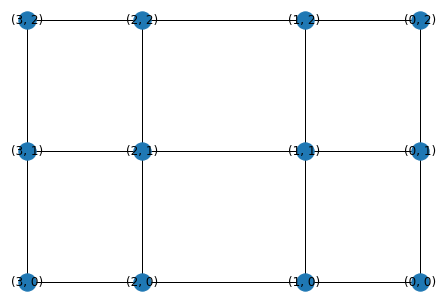

In [1]:
import networkx as nx
import numpy as np

G = nx.generators.lattice.grid_graph(dim=(3,4))
n_nodes = len(G)
print("Number of nodes:", n_nodes)

# labels of nodes are couples: (column,row)
nx.draw_spectral(G, with_labels=True)


In [3]:
# Construct a dictionary that maps the label of nodes  
# (from (0,0) to (3,2)) to their index (from 0 to n_nodes-1)
indices = dict()
for i in range(n_nodes):
    indices[list(G.nodes)[i]] = i
print(indices)

{(0, 0): 0, (0, 1): 1, (0, 2): 2, (1, 0): 3, (1, 1): 4, (1, 2): 5, (2, 0): 6, (2, 1): 7, (2, 2): 8, (3, 0): 9, (3, 1): 10, (3, 2): 11}


We now simulate the averaging dynamics on this network, when the set of stubborn nodes is $ S = \{(0,0), (3,2)\} $ with the input values $u_{(0,0)} = 0$ and $u_{(3,2)} = 1$. 

In [4]:
# Number of iterations
n_iter = 50;
    
# Stubborn and regular nodes
stubborn = [(0,0), (3,2)];
stubborn_id = [indices.get(key) for key in stubborn]
regular = [node for node in G.nodes if node not in stubborn]
regular_id = [id for id in range(n_nodes) if id not in stubborn_id]
print("Stubborn nodes:", stubborn)
print("Regular nodes:", regular)

# Input to stubborn nodes
u = [0,1]


# P matrix
A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

# Submatrices
# Using ix_ one can construct index arrays that will 
# index a cross product. 
# a[np.ix_([1,3],[2,5])] returns the array [[a[1,2] a[1,5]], [a[3,2] a[3,5]]].
Q = P[np.ix_(regular_id, regular_id)]
E = P[np.ix_(regular_id, stubborn_id)]

# Sample a random initial condition for regular nodes
ic = np.random.uniform(0,1,len(regular))

# Set the initial condition for the dynamics
x = np.zeros((n_nodes,n_iter))
x[stubborn_id,0] = u;
x[regular_id,0] = ic;
print("Initial condition:", x[:,0])

# Evolve the opinion vector
for t in range(1,n_iter):
    x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
    x[stubborn_id, t] = x[stubborn_id, t-1];

x_final = x[:,n_iter-1]
for key in indices.keys():
    print(key, x_final[indices[key]])


Stubborn nodes: [(0, 0), (3, 2)]
Regular nodes: [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1)]
Initial condition: [0.         0.32438265 0.11336015 0.21653302 0.54402743 0.42681719
 0.76966158 0.30482228 0.75787496 0.61592033 0.46618086 1.        ]
(0, 0) 0.0
(0, 1) 0.2645284024569043
(0, 2) 0.3798100884565072
(1, 0) 0.30585174909991364
(1, 1) 0.4128706615438914
(1, 2) 0.49595833856918564
(2, 0) 0.5037658956474688
(2, 1) 0.5868640045798854
(2, 2) 0.6939453947432175
(3, 0) 0.6199225293934871
(3, 1) 0.7352718822034816
(3, 2) 1.0


To visualize the convergence process we can plot the trajectories of the opinions of regular nodes, starting from the initial condition where regular nodes have a random opinion drawn from a uniform distribution over $[0,1]$.

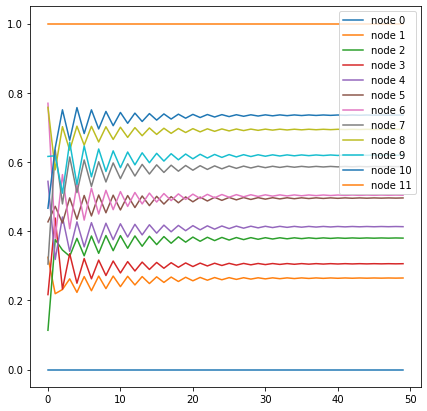

In [5]:
import matplotlib.pyplot as plt
    
fig = plt.figure(1, figsize=(7,7))
ax = plt.subplot(111)

for node in range(n_nodes):
    trajectory = x[node,:]
    ax.plot(trajectory, label='node {0:d}'.format(node))
    
ax.legend()

Note that the asymptotic opinions of regular nodes are independent from their initial opinions.

The average asymptotic opinion is 

In [6]:
average = np.average(x_final)
print("Average asymptotic opinion:", average)

Average asymptotic opinion: 0.4998990788911619


## Optimal placement of stubborn nodes
Suppose that node $(0,0)$ is stubborn with opinion $u_{(0,0)}=0$. We want to find the optimal position $(i,j)$ of a stubborn node with opinion $1$ in order to maximize the asymptotic average opinion.

A very simple approach is to consider all possible positions $(i,j)$ and pick the best one.

In [7]:
# Number of iterations
n_iter = 50;

# We will store final opinion vectors and 
# average of final opinions in dictionaries
# where the key is the position (i,j) of the 
# 1-stubborn agent
final_opinions = dict()
average_opinion = dict() 


for (i,j) in G.nodes:
    # Position (0,0) is occupied by the 0-stubborn node
    if (i,j)==(0,0):
        continue
        
    # Stubborn and regular nodes
    stubborn = [(0,0), (i,j)];
    stubborn_id = [indices.get(key) for key in stubborn]
    regular = [node for node in G.nodes if node not in stubborn]
    regular_id = [id for id in range(n_nodes) if id not in stubborn_id]
    print("Stubborn nodes:", stubborn)

    # Input to stubborn nodes
    u = [0,1]


    # P matrix
    A = nx.adjacency_matrix(G) # -> return type is scipy.sparse.csr_matrix
    A = A.toarray() # convert A to a numpy array
    degrees = np.sum(A,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ A

    # Submatrices
    Q = P[np.ix_(regular_id, regular_id)]
    E = P[np.ix_(regular_id, stubborn_id)]

    # Sample a random initial condition for regular nodes
    ic = np.random.uniform(0,1,len(regular))

    # Set the initial condition for the dynamics
    x = np.zeros((n_nodes,n_iter))
    x[stubborn_id,0] = u;
    x[regular_id,0] = ic;

    for t in range(1,n_iter):
        x[regular_id, t] = Q @ x[regular_id, t-1] + E @ x[stubborn_id, t-1]
        x[stubborn_id, t] = x[stubborn_id, t-1];

    final_opinions[(i,j)] = x[:,n_iter-1]
    average_opinion[(i,j)] = np.average(final_opinions[(i,j)])
    print("Average opinion:", average_opinion[(i,j)])

Stubborn nodes: [(0, 0), (0, 1)]
Average opinion: 0.6244316512299396
Stubborn nodes: [(0, 0), (0, 2)]
Average opinion: 0.500555604555063
Stubborn nodes: [(0, 0), (1, 0)]
Average opinion: 0.6696211990253641
Stubborn nodes: [(0, 0), (1, 1)]
Average opinion: 0.713823723981211
Stubborn nodes: [(0, 0), (1, 2)]
Average opinion: 0.6037734288897891
Stubborn nodes: [(0, 0), (2, 0)]
Average opinion: 0.6023667012830662
Stubborn nodes: [(0, 0), (2, 1)]
Average opinion: 0.6588759264377163
Stubborn nodes: [(0, 0), (2, 2)]
Average opinion: 0.5884106315698424
Stubborn nodes: [(0, 0), (3, 0)]
Average opinion: 0.49977418204495344
Stubborn nodes: [(0, 0), (3, 1)]
Average opinion: 0.5580011135071768
Stubborn nodes: [(0, 0), (3, 2)]
Average opinion: 0.5001280558933108


To visualize the dependence of the average asymptotic opinion on the position of the $1$-stubborn node we can plot the grid graph by setting each node's size and color according to the magnitude of the average asymptotic opinion when the $1$-stubborn is placed in such node.

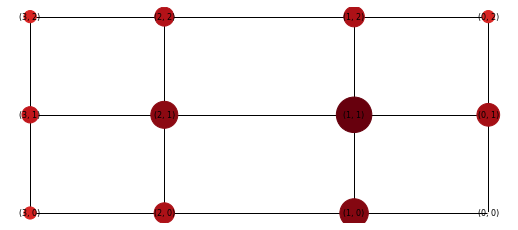

In [8]:
# add a dummy (0,0) entry to the dictionary
# to make its size = n_nodes
average_opinion[(0,0)] = 0

plt.figure(1, figsize=(7,3))
nx.draw(G, 
        pos = nx.spectral_layout(G),
        with_labels=True, 
        node_size = [np.exp(10*average_opinion[node]) for node in G.nodes],
        node_color= [average_opinion[node] for node in G.nodes],
        font_size=8,
        # node's colors are on the red scale
        cmap=plt.cm.Reds)

The optimal placements of the 1-stubborn player are the maximizers of the final average opinion:

In [9]:
# convert the average opinion values from dict_values to numpy array
avg = np.fromiter(average_opinion.values(),dtype=float)

optimal_place = [place for place in average_opinion.keys() if average_opinion[place]==np.max(avg)]
print("Optimal placements:", optimal_place)

Optimal placements: [(1, 1)]
